#**Computational Drug Discovery**
##**1) Descriptor Calculation and Dataset Preparation**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [3]:
! pwd

/content


## **Installing libraries**

Install the ChEMBL web service package to retrieve bioactivity data from the ChEMBL Database.

In [4]:
! pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 11.0 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
  Created wheel for easydict: filename=easydict-1.9-py3-none-any.whl size=6349 sha256=347589d8afd47b296b17eaac42bd67ffce198885c81d1660d80efede1a62b80d
  Stored in directory: /root/.cache/pip/wheels/88/96/68/c2be18e7406804be2e593e1c37845f2dd20ac2ce1381ce40b0
Successfully built easydict


## **Importing libraries** 

In [5]:
# Import necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

## **Search for Target protein**
### **Target search for Acetylcholinesterase**
Acetylcholinesterase(AChE) is a cholinergic enzyme primarily found at postsynaptic neuromuscular junctions, especially in muscles and nerves. It immediately breaks down or hydrolyzes acetylcholine (ACh), a naturally occurring neurotransmitter, into acetic acid and choline.

In [ ]:
# Target search for coronavirus
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
targets

### **Select and retrieve bioactivity data for *Human Acetylcholinesterase* (first entry)**

In [7]:
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL220'

Retrieve only bioactivity data for *Human Acetylcholinesterase* (CHEMBL220) that are reported as pChEMBL values.

In [8]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [9]:
type(res)

chembl_webresource_client.query_set.QuerySet

In [10]:
df = pd.DataFrame.from_dict(res)

In [11]:
df.to_csv('acetylcholinesterase_01_bioactivity_data_raw.csv', index=False)

In [12]:
len(df)

8205

In [ ]:
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2

In [14]:
len(df2.canonical_smiles.unique())

5664

In [ ]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

## **Data pre-processing of the bioactivity data**
#### **Combine the 3 columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame**

In [ ]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

### **Labeling compounds as either being active, inactive or intermediate**
The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [17]:
bioactivity_threshold = []
for i in df3.standard_value:
  j = float(i)
  #print(type(j))
  if j >= 10000:
    bioactivity_threshold.append("inactive")
  elif j <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df3 = df3.set_index(pd.Series(bioactivity_class.index))
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4

In [19]:
df_no_smiles = df4.drop(columns='canonical_smiles')


In [20]:
smiles = []

for i in df4.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

In [22]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [23]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [ ]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski




Now combine the bioactivity dataframe and the lipinski dataframe

In [ ]:
df_combined = pd.concat([df4,df_lipinski], axis=1)
df_combined

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [26]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [ ]:
df_combined["standard_value"] = pd.to_numeric(df_combined["standard_value"], downcast="float")
df_combined.standard_value.describe()

In [28]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        if i ==0:
          i = 0.000005
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm

In [ ]:
df_norm.standard_value_norm.describe()

In [31]:
df_final = pIC50(df_norm)
df_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  del sys.path[0]


,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5659,CHEMBL4779440,Brc1ccc([N+]2=Cc3ccccc3CC2)cc1.[Br-],inactive,287.180,3.7683,0.0,0.0,4.978811
5660,CHEMBL417799,C[n+]1cc2c3c(ccc2c2ccc4cc5c(cc4c21)OCO5)OCO3,intermediate,332.335,3.4281,0.0,4.0,5.913640
5661,CHEMBL13045,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,intermediate,348.378,3.7166,0.0,4.0,5.838632
5662,CHEMBL3085398,C=CC(C)(C)c1cc([C@@H]2CC(=O)c3c(O)cc(O)c(CC=C(...,inactive,424.493,5.1878,4.0,6.0,4.537902


In [32]:
df_final.pIC50.describe()

count    5664.000000
mean        5.822489
std         1.592705
min         1.000000
25%         4.769551
50%         5.626170
75%         6.843527
max        14.301030
Name: pIC50, dtype: float64

In [33]:
df_final.to_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv')

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [ ]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [35]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

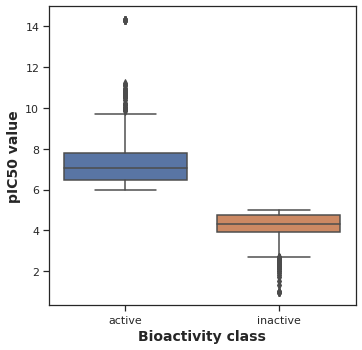

In [38]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [39]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [40]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.0,0.05,Different distribution (reject H0)


## **MW**

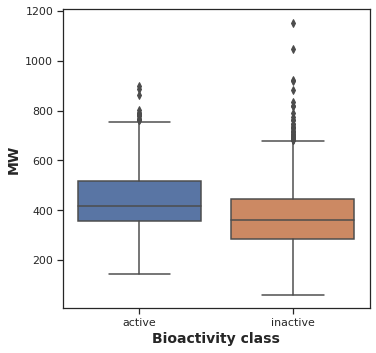

In [41]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [42]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1550035.5,4.592832e-65,0.05,Different distribution (reject H0)


#### **LogP**

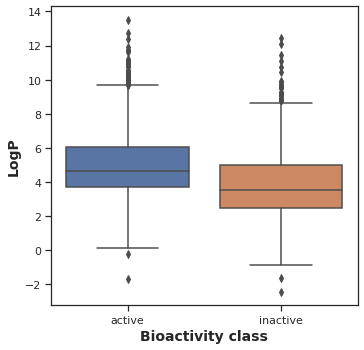

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [44]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1464386.0,4.878722e-82,0.05,Different distribution (reject H0)


#### **NumHDonors**

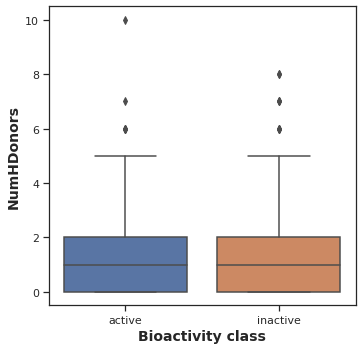

In [45]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [46]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1909212.5,3.871525e-17,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

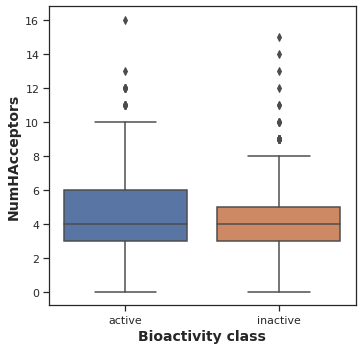

In [47]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [48]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2020224.5,8.201329e-08,0.05,Different distribution (reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

# **=================== PaDEL-Descriptor ==================**




In [54]:
import pandas as pd
BioAct = pd.read_csv('acetylcholinesterase_04_bioactivity_data_3class_pIC50.csv', index_col=0)
BioAct

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5659,CHEMBL4779440,Brc1ccc([N+]2=Cc3ccccc3CC2)cc1.[Br-],inactive,287.180,3.7683,0.0,0.0,4.978811
5660,CHEMBL417799,C[n+]1cc2c3c(ccc2c2ccc4cc5c(cc4c21)OCO5)OCO3,intermediate,332.335,3.4281,0.0,4.0,5.913640
5661,CHEMBL13045,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,intermediate,348.378,3.7166,0.0,4.0,5.838632
5662,CHEMBL3085398,C=CC(C)(C)c1cc([C@@H]2CC(=O)c3c(O)cc(O)c(CC=C(...,inactive,424.493,5.1878,4.0,6.0,4.537902


In [55]:
selection = ['canonical_smiles','molecule_chembl_id']
BioAct_selection = BioAct[selection]
BioAct_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [56]:
! cat molecule.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478


## **Calculate fingerprint descriptors**


In [57]:
! cat molecule.smi | wc -l

5664


In [ ]:
! unzip padel.zip

In [ ]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv

## **Preparing the X and Y Data Matrices**

### **X data matrix**

In [78]:
df3_XN = pd.read_csv('descriptors_output.csv')
df3_XN

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL133897,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL336398,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,CHEMBL3900117,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5660,CHEMBL417799,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5661,CHEMBL13045,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5662,CHEMBL253998,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
df3_X = df3_XN.set_index('Name')



**Change the indeces to make sure when we add PIC50 that PADEL fingerprints mactch the correct Chemble_ID**

In [80]:
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
Name,,,,,,,,,,,,,,,,,,,,,
CHEMBL133897,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL336398,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL130628,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL131588,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL130478,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL3900117,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL417799,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CHEMBL13045,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# **Y variable**

In [81]:
BioAct.rename(columns = {'molecule_chembl_id':'Name'}, inplace = True)

In [82]:
BioAct

,Name,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5659,CHEMBL4779440,Brc1ccc([N+]2=Cc3ccccc3CC2)cc1.[Br-],inactive,287.180,3.7683,0.0,0.0,4.978811
5660,CHEMBL417799,C[n+]1cc2c3c(ccc2c2ccc4cc5c(cc4c21)OCO5)OCO3,intermediate,332.335,3.4281,0.0,4.0,5.913640
5661,CHEMBL13045,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,intermediate,348.378,3.7166,0.0,4.0,5.838632
5662,CHEMBL3085398,C=CC(C)(C)c1cc([C@@H]2CC(=O)c3c(O)cc(O)c(CC=C(...,inactive,424.493,5.1878,4.0,6.0,4.537902


In [83]:
BA = BioAct.set_index('Name')

In [84]:
BA

,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
Name,,,,,,,
CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.8032,0.0,6.0,6.124939
CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.5546,0.0,5.0,7.000000
CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.3574,0.0,5.0,4.301030
CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.7069,0.0,5.0,6.522879
CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.0953,0.0,6.0,6.096910
...,...,...,...,...,...,...,...
CHEMBL4779440,Brc1ccc([N+]2=Cc3ccccc3CC2)cc1.[Br-],inactive,287.180,3.7683,0.0,0.0,4.978811
CHEMBL417799,C[n+]1cc2c3c(ccc2c2ccc4cc5c(cc4c21)OCO5)OCO3,intermediate,332.335,3.4281,0.0,4.0,5.913640
CHEMBL13045,COc1ccc2c(c[n+](C)c3c4cc5c(cc4ccc23)OCO5)c1OC,intermediate,348.378,3.7166,0.0,4.0,5.838632


In [85]:
df3_Y = BA['pIC50']
df3_Y

Name
CHEMBL133897     6.124939
CHEMBL336398     7.000000
CHEMBL131588     4.301030
CHEMBL130628     6.522879
CHEMBL130478     6.096910
                   ...   
CHEMBL4779440    4.978811
CHEMBL417799     5.913640
CHEMBL13045      5.838632
CHEMBL3085398    4.537902
CHEMBL253998     8.193820
Name: pIC50, Length: 5664, dtype: float64

## **Combining X and Y variable**

I will use merge rather than concat to be sure that each fingerprint has PIC50 values and I won't get NAN

In [86]:
dataset3 = pd.merge(df3_X,df3_Y, left_index=True, right_index=True)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
Name,,,,,,,,,,,,,,,,,,,,,
CHEMBL133897,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
CHEMBL336398,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
CHEMBL130628,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
CHEMBL131588,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
CHEMBL130478,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL3900117,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.974694
CHEMBL417799,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.913640
CHEMBL13045,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.838632


In [87]:
dataset3.to_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

# ***Build Machine learning Model _ Regression Model : Random Forest*** 

---




In [88]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [90]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.301030
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.974694
5660,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.913640
5661,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.838632
5662,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.193820


## **3. Input features**
The ***Acetylcholinesterase*** data set contains 881 input features and 1 output variable (pIC50 values).

### **3.1. Input features**

In [91]:
X = df.drop('pIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5659,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5660,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5661,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5662,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### **3.2. Output features**

In [92]:
Y = df.pIC50
Y

0       6.124939
1       7.000000
2       6.522879
3       4.301030
4       6.096910
          ...   
5659    5.974694
5660    5.913640
5661    5.838632
5662    8.193820
5663    4.537902
Name: pIC50, Length: 5664, dtype: float64

### **3.3. Remove low variance features**

In [93]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [94]:
X.shape

(5664, 142)

## **4. Data split (80/20 ratio)**

In [96]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [97]:
X_train.shape, Y_train.shape

((4531, 142), (4531,))

In [98]:
X_test.shape, Y_test.shape

((1133, 142), (1133,))

### **Build the ML model using Random Forest**

In [99]:
np.random.seed(100)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)

In [100]:
r2

0.700309186679287

In [101]:
Y_pred = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


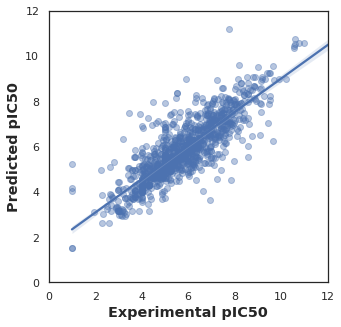

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show
plt.savefig('PedictionpIC50.pdf')

# **Comparing Regressors**
**Comparing several ML algorithms for build regression models of acetylcholinesterase inhibitors.**



## **1. Import libraries**

In [1]:
! pip install lazypredict

In [2]:
! pip install sklearn

In [ ]:

#scikit-learn==0.23.1

In [3]:
import pandas as pd
import seaborn as sns
import lazypredict

In [4]:
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('acetylcholinesterase_06_bioactivity_data_3class_pIC50_pubchem_fp.csv')

In [6]:
X = df.drop('pIC50', axis=1)
Y = df.pIC50

In [7]:
# Examine X dimension
X.shape

(5664, 881)

In [8]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(5664, 142)

In [24]:
# Perform data splitting using 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [19]:
X_test.shape

(1133, 142)

In [20]:
X_train.shape

(4531, 142)

In [21]:
Y_test.shape

(1133,)

In [22]:
Y_train.shape

(4531,)

## **4. Compare ML algorithms**

In [47]:
# Defines and builds multi ML models
reg = LazyRegressor(verbose=0 ,ignore_warnings=True, custom_metric=None)


In [48]:
# Performance table of the training set (80% subset)
models_train,predictions_train = reg.fit(X_train, X_train, Y_train, Y_train)
predictions_train

100%|██████████| 42/42 [02:25<00:00,  3.46s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.93,0.93,0.41,0.21
ExtraTreeRegressor,0.93,0.93,0.41,0.20
ExtraTreesRegressor,0.93,0.93,0.41,7.83
GaussianProcessRegressor,0.93,0.93,0.41,13.04
RandomForestRegressor,0.91,0.91,0.48,9.83
XGBRegressor,0.90,0.90,0.50,3.55
BaggingRegressor,0.89,0.90,0.51,0.84
MLPRegressor,0.88,0.88,0.54,26.98
HistGradientBoostingRegressor,0.77,0.78,0.75,16.40


In [49]:
models_train.to_csv('Regressors_trained.csv', index=True)

In [40]:
# Performance table of the test set (20% subset)
model_test, regressors_test = reg.fit(X_train, X_test, Y_train, Y_test)


100%|██████████| 42/42 [01:13<00:00,  1.74s/it]


In [41]:
print(model_test)

                                         Adjusted R-Squared  \
Model                                                         
XGBRegressor                                           0.66   
RandomForestRegressor                                  0.66   
BaggingRegressor                                       0.64   
HistGradientBoostingRegressor                          0.62   
LGBMRegressor                                          0.62   
MLPRegressor                                           0.58   
SVR                                                    0.53   
NuSVR                                                  0.52   
ExtraTreesRegressor                                    0.52   
KNeighborsRegressor                                    0.51   
DecisionTreeRegressor                                  0.48   
ExtraTreeRegressor                                     0.45   
GradientBoostingRegressor                              0.42   
TransformedTargetRegressor                             

In [44]:
model_test.to_csv('regressors.csv', index=True)

## **5. Data visualization of model performance**

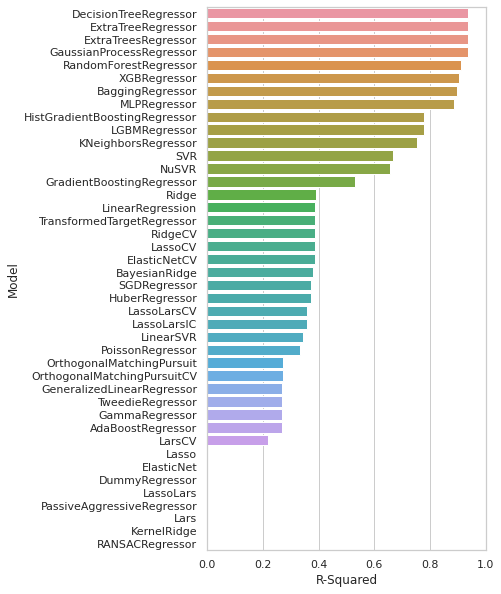

In [50]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))
plt.savefig('R_squared_trained.pdf')

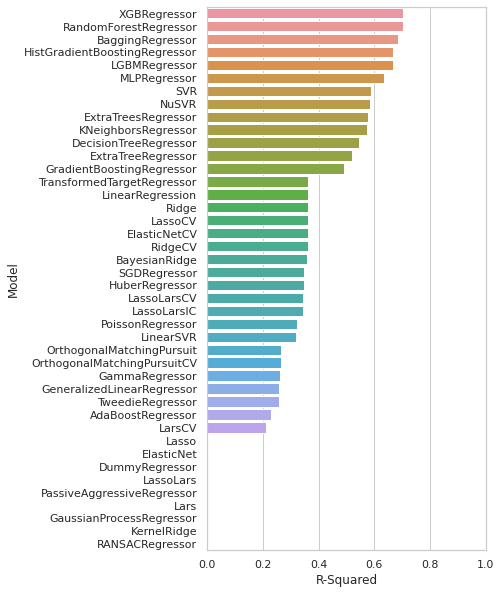

In [51]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=regressors_test.index, x="R-Squared", data=regressors_test)
ax.set(xlim=(0, 1))
plt.savefig('R_squared_test.pdf')

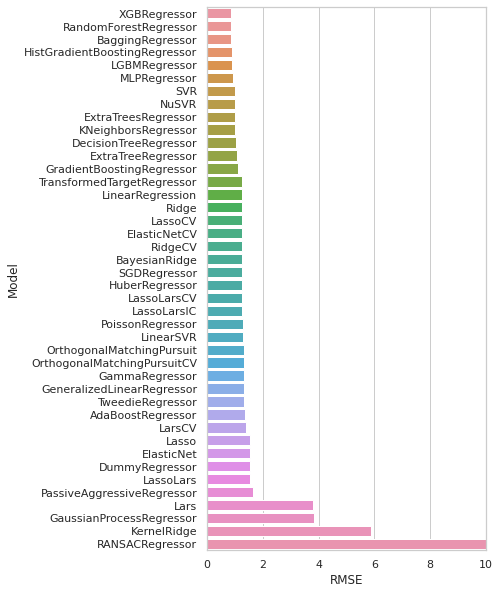

In [53]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=regressors_test.index, x="RMSE", data=regressors_test)
ax.set(xlim=(0, 10))
plt.savefig('RMSE_test.pdf')

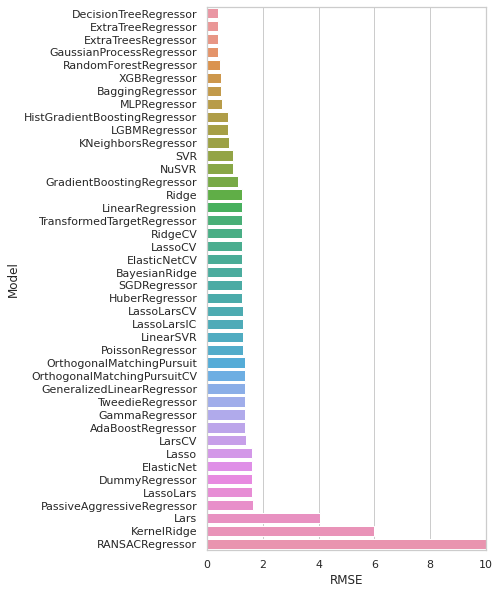

In [52]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))
plt.savefig('RMSE_trained.pdf')

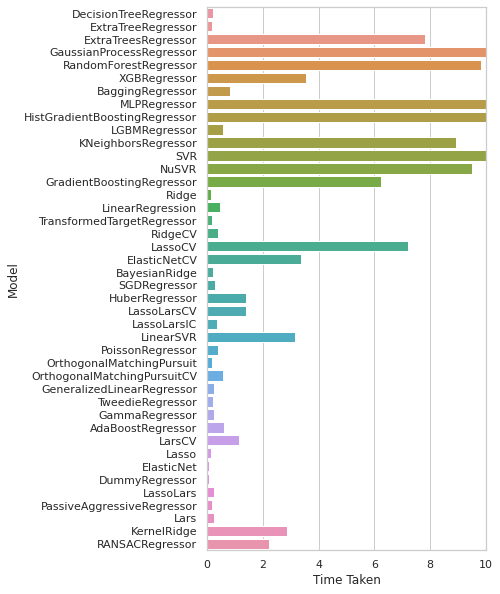

In [54]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))
plt.savefig('calculation_time.pdf')

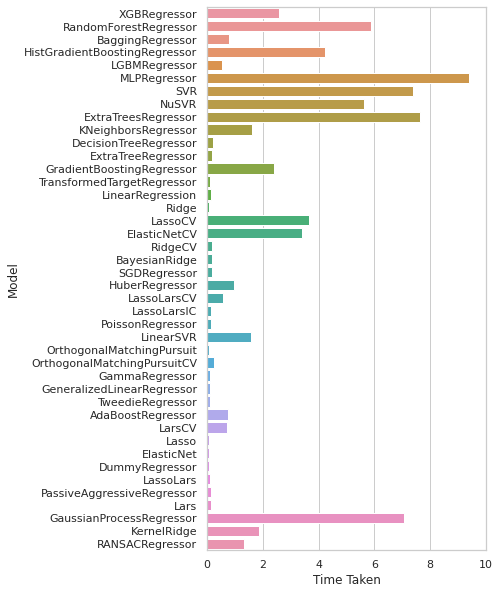

In [55]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=regressors_test.index, x="Time Taken", data=regressors_test)
ax.set(xlim=(0, 10))
plt.savefig('calculation_time_test.pdf')